In [1]:
#Analyzing metagenomic reads mapping to mouse microbiome gene reference

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from multiprocessing import Pool
from functools import reduce 
from Bio import SeqIO

Preprocess blast output
```
os.mkdir('ipynb_out')
#os.mkdir('read_counts_outdir')
os.mkdir('sample_gene_readcounts')
os.mkdir('sample_rpkm')
#Remove headers and comments from BLAST output
! for file in results/*.out; do sample=$(echo $file | sed 's/results\/20210717GU//;s/.out//'); grep -v "^#" ${file} > ipynb_out/${sample}.txt; done
```

In [3]:
#Reference genes
EMGC_ref = pd.read_csv('EMGC_annotation_2.txt', sep='\t', index_col=0)
#! grep "^D" ko00001.keg | sed 's/D      //1' > ko.txt
konam = ['KO','gene']
koref = pd.read_csv('ko.txt', sep='  ', names=konam, index_col='KO')

/home/ec2-user/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


Get lengths of reference genes for RPKM calculations
```
#ref_fasta_recs = SeqIO.parse('blast/fasta/EMGC.gene.fasta', 'fasta')
lens_dict = dict()
ref_fasta_recs = SeqIO.parse('blast/fasta/EMGC.gene.fasta', 'fasta')
for rec in ref_fasta_recs:
    lens_dict[rec.id] = len(rec.seq)
pd.Series(lens_dict).to_csv('EMGC_lengths.txt')
```

In [4]:
EMGC_lengths = pd.read_csv('EMGC_lengths.txt', header=None, names=['gene','length_bp'])

In [5]:
EMGC_lengths['gene'] = [gene.split('|')[-1] for gene in EMGC_lengths['gene']]

In [6]:
#Filter BLAST results
def filter_blast(file):
    nam = ['qacc', 'sacc', 'evalue', 'qstart', 'qend', 'qlen', 'sstart',
           'send', 'slen', 'qseqid', 'sseqid']
    #results = pd.read_csv('outdir/20210717GUA1-S13.tsv', sep='\t', header=None, names=nam)
    results = pd.read_csv(file, sep='\t', header=None, names=nam)
    results['query_cov'] = (results['qend'] - results['qstart'] - 1)/results['qlen']
    #Require read to have
    #Min 85% coverage
    #Max e-value of 0.001
    filtered_results = results[(results['query_cov'] > 0.85) & (results['evalue'] < 0.001)]
    return(filtered_results)

#Annotate the results and return read counts
def ko_annotate(filtered_results, sample):
    annotated_filtered_results = filtered_results.join(EMGC_ref.set_index('SeqID'), 'sacc').KO.value_counts()
    gene_counts = pd.DataFrame(annotated_filtered_results).join(koref).drop_duplicates().sort_values('KO', ascending=False)
    gene_counts.rename(mapper={'KO':sample}, axis=1, inplace=True)
    #If gene name not available, use KO number only
    for nameless_KO in gene_counts[gene_counts['gene'].isna()].index.tolist():
        gene_counts.loc[nameless_KO,'gene'] = nameless_KO
    return(gene_counts)

def write_read_counts_file(blastoutput):
    sample = blastoutput.replace('.txt','') #get sample name
    sample_blastfilt = filter_blast('ipynb_out/' + blastoutput)
    sample_gene_readcounts = sample_blastfilt.drop_duplicates(subset=['sacc','qacc'])['sacc'].value_counts()
    sample_gene_readcounts.to_csv('sample_gene_readcounts/' + sample + '.csv')
    temp = pd.DataFrame(sample_gene_readcounts).join(EMGC_lengths.set_index('gene'))
    #Get number of reads after QC in each sample
    rec_dict = SeqIO.to_dict(SeqIO.parse("blast/queries/20210717GU" + sample + "_filtered.fasta", 'fasta'))
    total_reads_sample = len(rec_dict.keys())
    rpkm_sample = temp['sacc']/((temp['length_bp']/1000)*(total_reads_sample/10**6))
    rpkm_sample.to_csv('sample_rpkm/' + sample + '.csv')
#     sample = blastoutput.replace('.txt','') #get sample name
#     sample_blastfilt = filter_blast('ipynb_out/' + blastoutput)
#     sample_counts = ko_annotate(sample_blastfilt, sample)
#     sample_counts.to_csv('read_counts_outdir/' + sample + '.txt')

In [ ]:
#We are mapping to genes, multiple genes may belong to the same KO category

#First, report RPKM of genes 
#Later, group or categorize as KO

In [9]:
readcount_frames = []
for outfile in os.listdir('sample_gene_readcounts'):
    sample = outfile.replace('.csv','') #get sample name
    readcount_frames.append(pd.read_csv('sample_gene_readcounts/' + outfile, index_col=0, names=['gene', sample]))#.set_index('gene'))
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['gene'],
                                            how='outer'), readcount_frames)
#df_merged.to_csv('rpkm_all_samples.csv')
df_merged.fillna(0, inplace=True)

In [10]:
#Add up readcounts from the same KO
groupedbyko = df_merged.join(EMGC_ref[['SeqID','KO']].set_index('SeqID')).groupby('KO')
df = pd.DataFrame()
for name, group in groupedbyko:
    df = df.append(pd.Series(np.sum(group.drop(labels=['KO'], axis=1)), name=name))
#We added up read counts of each KO within each sample
df.to_csv('read_counts_all_samples_summedbyko.csv')

In [119]:
#Generate RPKM counts for each sample
with Pool(8) as p:
    p.map(write_read_counts_file, os.listdir('ipynb_out'))

/home/ec2-user/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
/home/ec2-user/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
/home/ec2-user/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
/home/ec2-user/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarni

In [4]:
rpkm_frames = []
for outfile in os.listdir('sample_rpkm'):
    sample = outfile.replace('.csv','') #get sample name
    rpkm_frames.append(pd.read_csv('sample_rpkm/' + outfile, index_col=0, names=['gene', sample]))#.set_index('gene'))
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['gene'],
                                            how='outer'), rpkm_frames)
df_merged.to_csv('rpkm_all_samples.csv')
df_merged.fillna(0).shape

In [46]:
min_rpkm_genes = np.sum(df_merged > 100, axis=1) 
top_genes = min_rpkm_genes[min_rpkm_genes != 0].index.tolist()

In [ ]:
#What does it mean for a read to be "Unclassified"? Means that gene doesnt have KO classification.

In [94]:
#Add up RPKMs from the same KO
groupedbyko = df_merged.join(EMGC_ref[['SeqID','KO']].set_index('SeqID')).groupby('KO')
df = pd.DataFrame()
for name, group in groupedbyko:
    df = df.append(pd.Series(np.sum(group.drop(labels=['KO'], axis=1)), name=name))
#We added up RPKMs of each KO within each sample
df.to_csv('rpkm_all_samples_summedbyko.csv')

(4331, 40)

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

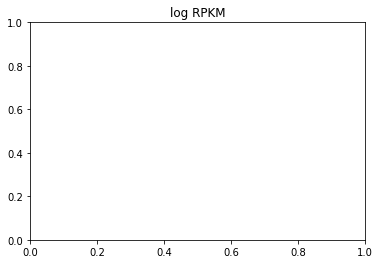

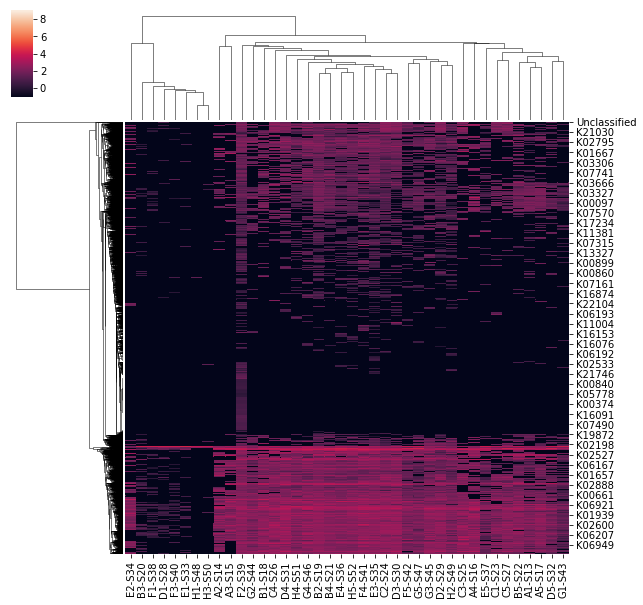

In [104]:
#Plot heatmap with raw reads (top genes)
plt.title('log RPKM')
cg = sns.clustermap(np.log10(df.replace(to_replace=0, value=0.1)))#.reset_index(drop=True))
                #cmap=sns.color_palette("Blues", as_cmap=True),
                #cmap="Blues",
                #row_colors=reordered_col_colors,
                #row_cluster=False, col_cluster=True,
                #method='single',
                #metric='hamming',
                #vmin=-0.25*100, vmax=100,
                #figsize=(80,30),
                #cbar_pos=(1.0, 0.6, 0.03, 0.2),
                #dendrogram_ratio=0.2,
                #linewidths=1, linecolor='0.9',
                #yticklabels=False,
                #xticklabels=1)

In [125]:
os.mkdir('sample_relab')

In [132]:
#Maybe would also be nice to calculate relative abundances
def write_relab_counts_file(blastoutput):
    sample = blastoutput.replace('.txt','') #get sample name
    sample_gene_readcounts = pd.read_csv('sample_gene_readcounts/' + sample + '.csv', header=None, names=['gene','read_counts'], index_col='gene')
    temp = pd.DataFrame(sample_gene_readcounts).join(EMGC_lengths.set_index('gene'))
    #Get number of reads after QC in each sample
    rec_dict = SeqIO.to_dict(SeqIO.parse("blast/queries/20210717GU" + sample + "_filtered.fasta", 'fasta'))
    total_reads_sample = len(rec_dict.keys())
    copynum_genes = temp['read_counts']/temp['length_bp']
    relab_sample = copynum_genes/np.sum(copynum_genes)
    relab_sample.to_csv('sample_relab/' + sample + '.csv')

In [134]:
#Generate RPKM counts for each sample
with Pool(8) as p:
    p.map(write_relab_counts_file, os.listdir('ipynb_out'))

/home/ec2-user/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  # This is added back by InteractiveShellApp.init_path()
/home/ec2-user/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  # This is added back by InteractiveShellApp.init_path()
/home/ec2-user/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to s

In [137]:
#Merge relative abundance 
relab_frames = []
for outfile in os.listdir('sample_relab'):
    sample = outfile.replace('.csv','') #get sample name
    relab_frames.append(pd.read_csv('sample_relab/' + outfile, index_col=0, names=['gene', sample]))#.set_index('gene'))
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['gene'],
                                            how='outer'), relab_frames)
df_merged.to_csv('relab_all_samples.csv')
df_merged.fillna(0).shape

(1427022, 40)

In [138]:
#Add up relative abundances from the same KO
groupedbyko = df_merged.join(EMGC_ref[['SeqID','KO']].set_index('SeqID')).groupby('KO')
df = pd.DataFrame()
for name, group in groupedbyko:
    df = df.append(pd.Series(np.sum(group.drop(labels=['KO'], axis=1)), name=name))
#We added up rel. abs. of each KO within each sample
df.to_csv('relab_all_samples_summedbyko.csv')

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

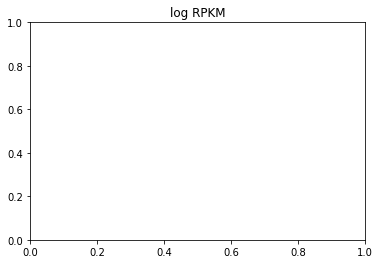

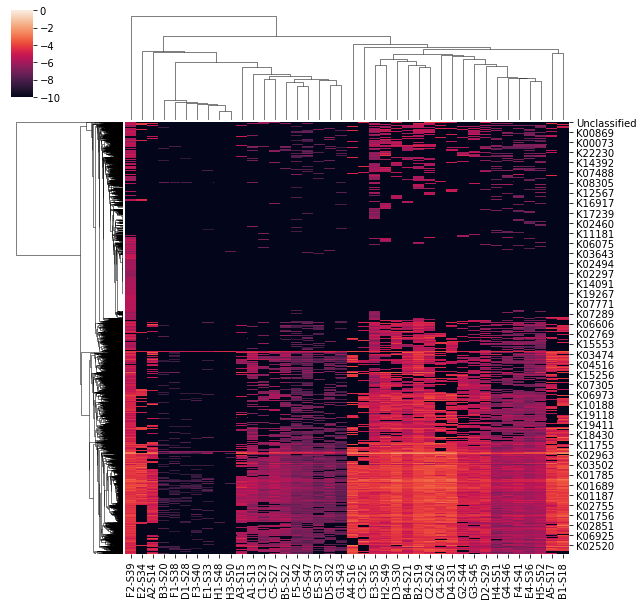

In [147]:
#Plot heatmap with raw reads (top genes)
plt.title('log RPKM')
cg = sns.clustermap(np.log10(df.replace(to_replace=0, value=10**-10)))#.reset_index(drop=True))
                #cmap=sns.color_palette("Blues", as_cmap=True),
                #cmap="Blues",
                #row_colors=reordered_col_colors,
                #row_cluster=False, col_cluster=True,
                #method='single',
                #metric='hamming',
                #vmin=-0.25*100, vmax=100,
                #figsize=(80,30),
                #cbar_pos=(1.0, 0.6, 0.03, 0.2),
                #dendrogram_ratio=0.2,
                #linewidths=1, linecolor='0.9',
                #yticklabels=False,
                #xticklabels=1)

In [ ]:
#Add sample labels
#  20210717GU[Mouse label A-H][Sample label 1-5].
#     Mouse labels A-D correspond to Jackson Labs mice whereas E-H correspond to Envigo.
#     Sample labels 1-5 correspond to contents from duodenum(1), jejunum(2), ileum(3), cecum(4), colon(5).
sample_labels = {'A2-S14', 'A1-S13', 'A3-S15', 'A4-S16', 'A5-S17', 
                 'B1-S18', 'B2-S19', 'B3-S20', 'B4-S21', 'B5-S22', 
                 'C1-S23', 'C2-S24', 'C3-S25', 'C4-S26', 'C5-S27', 
                 'D1-S28', 'D2-S29', 'D3-S30', 'D4-S31', 'D5-S32',
                 'E1-S33', 'E2-S34', 'E3-S35', 'E4-S36', 'E5-S37', 
                 'F1-S38', 'F2-S39', 'F3-S40', 'F4-S41', 'F5-S42', 
                 'G1-S43', 'G2-S44', 'G3-S45', 'G4-S46', 'G5-S47', 
                 'H1-S48', 'H2-S49', 'H3-S50', 'H4-S51', 'H5-S52'}

In [98]:
qc_reads_dict = dict()
#Get number of reads after QC in each sample
for query in os.listdir("blast/queries/"):
    sample = query.replace("_filtered.fasta", "").replace("20210717GU","")
    rec_dict = SeqIO.to_dict(SeqIO.parse("blast/queries/20210717GU" + sample + "_filtered.fasta", 'fasta'))
    total_reads_sample = len(rec_dict.keys())
    qc_reads_dict[sample] = total_reads_sample

In [100]:
qc_reads_dict

{'A2-S14': 24691,
 'A1-S13': 160564,
 'A3-S15': 13843,
 'A4-S16': 14539,
 'A5-S17': 89157,
 'B1-S18': 33097,
 'B2-S19': 363078,
 'B3-S20': 290361,
 'B4-S21': 194924,
 'B5-S22': 111870,
 'C1-S23': 41666,
 'C2-S24': 329084,
 'C3-S25': 18013,
 'C4-S26': 35473,
 'C5-S27': 46514,
 'D1-S28': 328909,
 'D2-S29': 329041,
 'D3-S30': 167132,
 'D4-S31': 56422,
 'D5-S32': 69846,
 'E1-S33': 151703,
 'E2-S34': 15615,
 'E3-S35': 574240,
 'E4-S36': 237814,
 'E5-S37': 97617,
 'F1-S38': 438105,
 'F2-S39': 425322,
 'F3-S40': 407893,
 'F4-S41': 150381,
 'F5-S42': 144040,
 'G1-S43': 187831,
 'G2-S44': 58471,
 'G3-S45': 71531,
 'G4-S46': 104892,
 'G5-S47': 169402,
 'H1-S48': 111961,
 'H2-S49': 420145,
 'H3-S50': 107841,
 'H4-S51': 128968,
 'H5-S52': 264516}

In [2]:
! head ko00001.json

{
	"name":"ko00001",
	"children":[
	{
		"name":"09100 Metabolism",
		"children":[
		{
			"name":"09101 Carbohydrate metabolism",
			"children":[
			{
